**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [ ]:

#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [2]:
a = [i for i in range(10)]
a[0:int(10 * 0.2 + 1)]

[0, 1, 2]

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('../../ELO/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../../ELO/new_merchant_transactions.csv')

In [5]:
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [6]:
df_hist_trans['merchant_id'].nunique() 

326311

In [ ]:
# for df in [df_new_merchant_trans,df_hist_trans]:
#     df['purchase_amount'].clip(upper = 1.5, inplace = True)
    

In [ ]:
#使用countVectorizer对category特征进行处理，别人号称可以提升 千分之3
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(token_pattern='\w{1,}') 

**Purchasing Journeys**

[An Introduction to Predictive Customer Lifetime Value Modeling](https://www.datascience.com/blog/intro-to-predictive-modeling-for-customer-lifetime-value)

![](https://d2mxuefqeaa7sj.cloudfront.net/s_60ECB163AE4078E84C49514ED5D5B38C222B9C0EA718BEA3759DABF297034DEB_1488169955068_file.png)

In [7]:
hist_monthly_perchase_cnts = df_hist_trans.groupby('card_id').month_lag.value_counts().unstack()
hist_monthly_perchase_cnts.fillna(0, inplace=True)
hist_monthly_perchase_cnts.columns = [f'hist_per_cnts_month_lag{col}' for col in hist_monthly_perchase_cnts.columns]
new_merchant_monthly_perchase_cnts = df_new_merchant_trans.groupby('card_id').month_lag.value_counts().unstack()
new_merchant_monthly_perchase_cnts.fillna(0, inplace=True)
new_merchant_monthly_perchase_cnts.columns = [f'new_merchant_per_cnts_month_lag{col}' for col in new_merchant_monthly_perchase_cnts.columns]
df_train = df_train.join(hist_monthly_perchase_cnts, on='card_id')
df_train = df_train.join(new_merchant_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(hist_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(new_merchant_monthly_perchase_cnts, on='card_id')

In [8]:
# 结果会从 3.675 变成 3.679 ，so sad
# i = 0
# aggs = {}
# aggs['purchase_amount'] = ['mean']
# for df in [df_hist_trans,df_new_merchant_trans]:
#     df['purchase_amount'] = df['purchase_amount'].astype(np.float32)
#     df_month_purchase_cnts = df.groupby(['card_id','month_lag']).agg(aggs).unstack()
#     df_month_purchase_cnts.fillna(0, inplace = True)
#     df_train = df_train.join(df_month_purchase_cnts, on = 'card_id')
#     df_test = df_test.join(df_month_purchase_cnts, on = 'card_id')
#     if i == 0:
#         prefix = 'hist_'
#     else:
#         prefix = 'new_merchant_'
#     i += 1
#     df_train.columns = [prefix + c[0] + c[1] + str(c[2]) if type(c) is tuple else c for c in df_train.columns ]
#     df_test.columns = [prefix + c[0] + c[1] + str(c[2]) if type(c) is tuple else c for c in df_test.columns ]
#     del df_month_purchase_cnts
#     gc.collect()
#     time.sleep(5)

In [9]:
df_hist_trans.purchase_date=pd.to_datetime(df_hist_trans.purchase_date)
pur_date=df_hist_trans[df_hist_trans.month_lag==0].groupby('card_id').purchase_date.max()
card_id_nan_unique=df_hist_trans[df_hist_trans.card_id.isin(pur_date.index)==False].card_id.unique()
df=pd.DataFrame(card_id_nan_unique)
df['month_lag_date']=pd.to_datetime('2018-02') # Seetting all nan values to 2018 Feb
df.set_index(0,inplace=True)
new_map=df.month_lag_date
method=pur_date.append(new_map)
del df,pur_date
gc.collect()
time.sleep(5)

In [10]:
for df in [df_hist_trans,df_new_merchant_trans]:
#     df['category_2'].fillna(1.0,inplace=True)
#     df['category_3'].fillna('A',inplace=True)
#     df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    #修改特征
    df['category_2'].fillna(-1,inplace=True)
    df['category_3'].fillna('other',inplace=True)
    df['merchant_id'].fillna('other',inplace=True)
#     df.loc[df['installments'].isin([999,-1]),'installments'] = 0 

In [11]:
def get_new_columns(name,aggs):
    #for for 写法 nice
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [12]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    ##Think about this part!
    ## This line of code may be missleading since there is no single ref date. 
    df['month_diff'] = ((datetime.datetime(2018,6,1) - df['purchase_date']).dt.days)//30 # original code
    df['month_diff'] += df['month_lag']
    
    ## removing 'month_diff' reduces LB score to 3.682
    ## This line of code can be also missleading since for new merchant hist it might be negative. But why we care about it.
    #df['month_diff'] = ((df['card_id'].map(method) - df['purchase_date']).dt.days)//30 # method that I used in my code
    
    ##But we already have mongth lag for each purchase! So we don't really need it!
    ### month_diff seems to be important feature think more about it
    
    # This makes it even more irrelevant for my case since it will be equal to zero in most of the cases.So, let's remove it for my case
    #df['month_diff'] += df['month_lag']

In [13]:
(pd.to_datetime('2018-12-30')-pd.to_datetime('2019-12-30')).days//30

-13

In [14]:
#因为根据auth_flag 将特征分成了两部分，这里聚合一个全局的auth_flag 特征
aggs = {}
aggs['purchase_amount'] = ['sum']
# aggs['installments'] = ['sum','max','min','mean','var','median']
aggs['authorized_flag'] = ['sum', 'mean','std']
aggs['card_id'] = ['size']
auth_flag = df_hist_trans.groupby(['card_id']).agg(aggs)
auth_flag.columns = get_new_columns('auth_flag',aggs)
auth_flag.reset_index(inplace=True)
df_train = df_train.merge(auth_flag,on='card_id',how='left')
df_test = df_test.merge(auth_flag,on='card_id',how='left')
del auth_flag
gc.collect()

49

In [15]:
#对 authorized_flag进行结果编码
aggs = {}
for col in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
    df_hist_trans[col+'_auth_mean'] = df_hist_trans.groupby([col])['authorized_flag'].transform('mean')
    df_hist_trans[col+'_auth_sum'] = df_hist_trans.groupby([col])['authorized_flag'].transform('sum') 
    aggs[col+'_auth_mean'] = ['mean']
    aggs[col+'_auth_sum'] = ['sum'] 
auth_encoder = df_hist_trans.groupby(['card_id']).agg(aggs)
auth_encoder.columns = get_new_columns('auth_encoder',aggs)
auth_encoder.reset_index(inplace=True)
df_train = df_train.merge(auth_encoder,on='card_id',how='left')
df_test = df_test.merge(auth_encoder,on='card_id',how='left')
del auth_encoder
gc.collect()

35

In [16]:
def aggregate_per_month(prefix,history,agg_func):
    grouped = history.groupby(['card_id', 'month_lag'])
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = [prefix + '_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = [prefix + '_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True) 
    return final_group

In [17]:
# #对授权码 进行按月聚合
# agg_func = {'authorized_flag': [ 'sum', 'mean','median']}
# final_group =  aggregate_per_month('agg_per_month_total',df_hist_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group

In [18]:
authorized_transactions = df_hist_trans[df_hist_trans['authorized_flag'] == 1]
df_hist_trans = df_hist_trans[df_hist_trans['authorized_flag'] == 0]

In [19]:
df_hist_trans.shape

(2516909, 33)

In [20]:
# agg_func = {'purchase_amount': [ 'sum', 'mean', 'min', 'max', 'std']}
# final_group =  aggregate_per_month('agg_per_month_auth',authorized_transactions,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# final_group =  aggregate_per_month('agg_per_month_hist',df_hist_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# final_group =  aggregate_per_month('agg_per_month_hist_new',df_new_merchant_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# gc.collect()

In [21]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [22]:
i = 0
for df in [authorized_transactions,df_hist_trans]:
    aggs = {}
    for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',
                'state_id','city_id']:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','median']
    aggs['installments'] = ['sum','max','min','mean','var','median']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','median']
    
    ## I also remove this part since it is also irrelevant since it is equivelent to month_lag. But it makes it worser
    aggs['month_diff'] = ['mean','median']
#     aggs['authorized_flag'] = ['sum', 'mean','median']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    #产生交叉特征，内存有问题
    features = ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id'
               ,'merchant_id']
#     for coli in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#         for colj in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#             df[coli + colj] = df[coli].astype(str) + df[colj].astype(str)
#             features.append(coli + colj)
    for col in features:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum') 
        aggs[col+'_mean'] = ['mean']
        aggs[col+'_sum'] = ['sum'] 
#         添加特征，使用outlier进行编码
#         outliers_mean = df.groupby([col])['outliers'].mean()
#         outliers_sum = df.groupby([col])['outliers'].sum()
#         df[col+'_outliers_mean'] = df[col].map(outliers_mean)
#         df[col+'_outliers_sum'] = df[col].map(outliers_sum)
#         aggs[col+'_outliers_mean'] = ['mean']
#         aggs[col+'_outliers_sum'] =['sum']   
        
    if i == 0:
        prefix = 'auth_hist'
    else:
        prefix = 'hist'
    new_columns = get_new_columns(prefix,aggs)
    i += 1
    # df_hist_trans.sort_values(['card_id','purchase_date'],inplace = True)

    df_hist_trans_group = df.groupby('card_id').agg(aggs)
    df_hist_trans_group.columns = new_columns
    df_hist_trans_group.reset_index(drop=False,inplace=True)
    df_hist_trans_group[prefix + '_purchase_date_diff'] = (df_hist_trans_group[prefix + '_purchase_date_max'] - df_hist_trans_group[prefix + '_purchase_date_min']).dt.days
    df_hist_trans_group[prefix + '_purchase_date_average'] = df_hist_trans_group[prefix + '_purchase_date_diff']/df_hist_trans_group[prefix + '_card_id_size']
    ###Think about below line of code  
    ###up to now for history means month_lag_0 to purdate_min
#     df_hist_trans_group[prefix + '_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_max']).dt.days
    ### This is new feature but I change the name to the old name since it makes more sense. Total number of days from first purchase to month lag 0 (until promotion)
    df_hist_trans_group[prefix + '_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_min']).dt.days
    ### This is old feature but I change the name to [prefix + '_first_purchase'] from [prefix + '_purchase_date_uptonow']
    ### since it makes more sense. Number of days for the last purchase from month_lag_0
    df_hist_trans_group[prefix + '_first_purchase'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_max']).dt.days
    #下面这个特征考虑了：有的人可能购买频率较低，但是还是忠实粉丝的情况
#     df_hist_trans_group[prefix + '_purchase_date_uptonow_ave'] =  df_hist_trans_group[prefix + '_purchase_date_uptonow']/df_hist_trans_group[prefix + '_purchase_date_average']
    #每一个card中未授权消费次数
#     df_hist_trans_group[prefix + '_unauthorized_number'] = df_hist_trans_group[prefix + '_card_id_size'] - df_hist_trans_group[prefix + '_authorized_flag_sum']
    #最近活跃时间，确实是一个强特征，感觉可以再挖出来几个特征，比如最近5次消费时间，最近10次消费时间，如果值比较小，说明最近很活跃
    #没有效果
    # grouped =  df_hist_trans.groupby('card_id')['purchase_date']
    # df_hist_trans_group['hist_purchase_5thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(5)).dt.days
    # df_hist_trans_group['hist_purchase_3thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(3)).dt.days
    # df_hist_trans_group['hist_purchase_10thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(10)).dt.days
    df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
    df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
    del df_hist_trans_group
    gc.collect()
    time.sleep(5)
    #内存问题，暂时先放弃
#     for col in ['subsector_id','merchant_category_id','state_id','city_id']:
#         df[col]=df[col].astype(str)
#         grouped = df[['card_id',col]].groupby('card_id')[col].aggregate(lambda x: ' '.join(x))
#         cv_fit=cv.fit_transform(grouped)
#         cv_df = pd.DataFrame(cv_fit.toarray())
#         print(i,col)
#         if i == 1:
#             cv_df.columns = ['auth' + '_' + col + "_" + str(c) for c in cv_df.columns]
#         elif i == 2:
#              cv_df.columns = ['hist' + '_' + col + "_" + str(c) for c in cv_df.columns]
#         cv_df['card_id'] = grouped.index
#         df_train = df_train.merge(cv_df,on='card_id',how='left')
#         df_test = df_test.merge(cv_df,on='card_id',how='left')
#         del cv_df,grouped
#         gc.collect()
    del df
    gc.collect()
    time.sleep(5)

In [23]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,...,hist_merchant_category_id_mean_mean,hist_merchant_category_id_sum_sum,hist_city_id_mean_mean,hist_city_id_sum_sum,hist_merchant_id_mean_mean,hist_merchant_id_sum_sum,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_first_purchase
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0.0,0.0,0.0,0.0,...,13.846728,1.144478e+07,17.928541,7.615314e+07,12.858409,337518.250000,164.0,12.615385,224.0,59.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0.0,21.0,22.0,13.0,...,2.988992,2.014900e+06,16.378971,6.238182e+07,1.745633,8938.264648,299.0,27.181818,334.0,34.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,6.0,6.0,5.0,7.0,...,1.316483,1.042644e+06,7.287305,5.252981e+05,-0.559304,-1012.340759,56.0,28.000000,368.0,312.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.0,0.0,0.0,0.0,...,3.685194,2.026175e+06,2.260627,8.374476e+05,0.144859,1023.051819,37.0,7.400000,38.0,1.0


In [24]:
aggs = {}
#添加特征
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',
            'state_id','city_id']:
    aggs[col] = ['nunique']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var','median']
aggs['installments'] = ['sum','max','min','mean','var','median']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','median']

### Now we also need to remove from here since we already have month_lag
aggs['month_diff'] = ['mean','median']


aggs['weekend'] = ['sum', 'mean']
aggs['authorized_flag'] = ['sum', 'mean','median']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

#添加特征   
features = ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id'
               ,'merchant_id']
#产生交叉特征，内存有问题
# for coli in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#     for colj in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#         df_new_merchant_trans[coli + colj] = df_new_merchant_trans[coli].astype(str) + df_new_merchant_trans[colj].astype(str)
#         features.append(coli + colj)
for col in features:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    df_new_merchant_trans[col+'_sum'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('sum')
    aggs[col+'_mean'] = ['mean']
    aggs[col+'_sum'] = ['sum']
    #添加特征，使用outlier进行编码
#     outliers_mean = df.groupby([col])['outliers'].mean()
#     outliers_sum = df.groupby([col])['outliers'].sum()
#     df[col+'_outliers_mean'] = df[col].map(outliers_mean)
#     df[col+'_outliers_sum'] = df[col].map(outliers_sum)
#     aggs[col+'_outliers_mean'] = ['mean']
#     aggs[col+'_outliers_sum'] =['sum']   
    
new_columns = get_new_columns('new_hist',aggs)
# df_new_merchant_trans.sort_values(['card_id','purchase_date'],inplace = True)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']


# it is fine for new mech transaction history. This means total number of days from month_lag_0 ti kast purchase
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group['new_hist_purchase_date_max']).dt.days

# new feature for the first purchase.This means total number of days from month_lag_0 to first purchase.
df_hist_trans_group['new_hist_first_purchase'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group['new_hist_purchase_date_min']).dt.days

#下面这个特征考虑了：有的人可能购买频率较低，但是还是忠实粉丝的情况
# df_hist_trans_group['new_hist_purchase_date_uptonow_ave'] =  df_hist_trans_group['new_hist_purchase_date_uptonow']/df_hist_trans_group['new_hist_purchase_date_average']

#每一个card中未授权消费次数
df_hist_trans_group['new_hist_unauthorized_number'] = df_hist_trans_group['new_hist_card_id_size'] - df_hist_trans_group['new_hist_authorized_flag_sum']
# grouped = df_new_merchant_trans.groupby('card_id')['purchase_date']
# df_hist_trans_group['new_hist_purchase_5thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(5)).dt.days
# df_hist_trans_group['new_hist_purchase_3thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(3)).dt.days
# df_hist_trans_group['new_hist_purchase_10thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(10)).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()
del df_new_merchant_trans
gc.collect()
time.sleep(5)

In [25]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (df['card_id'].map(method) - df['first_active_month']).dt.days
    # 3.678，so bad
#     # add some interaction features
#     df['feature_1_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_1']
#     df['feature_2_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_2']
#     df['feature_3_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_3']
#     df['feature_1_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_1']
#     df['feature_2_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_2']
#     df['feature_3_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_3']
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    #添加特征
    df['auth_hist_first_buy'] = (df['auth_hist_purchase_date_min'] - df['first_active_month']).dt.days
    #修改特征
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min','auth_hist_purchase_date_max','auth_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    for f in ['auth_encoder_category_2_auth_sum_sum','auth_encoder_category_3_auth_sum_sum',
            'auth_encoder_state_id_auth_sum_sum','auth_encoder_subsector_id_auth_sum_sum',
            'auth_encoder_merchant_category_id_auth_sum_sum','auth_encoder_city_id_auth_sum_sum']:
        df[f] = df[f].astype(np.int64) * 1e-9
    #上面auth_flag已经聚合过了card_id_size ,purchase_amount
#     df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']  + df['auth_hist_card_id_size']
#     df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']+df['auth_hist_purchase_amount_sum']
#添加特征

for f in ['feature_1','feature_2','feature_3','month','dayofweek']:
    order_label1 = df_train.groupby([f])['outliers'].mean()
    df_train[f+'_outliers_mean'] = df_train[f].map(order_label1)
    df_test[f+'_outliers_mean'] = df_test[f].map(order_label1)
    
    order_label2 = df_train.groupby([f])['outliers'].sum()
    df_train[f+'_outliers_sum'] = df_train[f].map(order_label2)
    df_test[f+'_outliers_sum'] = df_test[f].map(order_label2)
    
#     order_label1 = df_train.groupby([f])['target'].mean()
#     df_train[f+'_target_mean'] = df_train[f].map(order_label1) 
#     df_test[f+'_target_sum'] = df_test[f].map(order_label1)
#     order_label2 = df_train.gorupby([f])['target'].sum()
#     df_train[f+'_target_sum'] = df_train[f].map(order_label2)
#     df_test[f+'_target_sum'] = df_test[f].map(order_label2)
 
# get_dummies 似乎有一点点不良影响
df_train = pd.get_dummies(df_train,columns =['feature_1','feature_2'])
df_test = pd.get_dummies(df_test,columns =['feature_1','feature_2'])

In [26]:
#首次购买的时间居然早于首次激活的时间，进行调整
df_train.loc[df_train['auth_hist_first_buy'] < 0, 'auth_hist_first_buy'] = -1
df_train.loc[df_train['hist_first_buy'] < 0, 'hist_first_buy'] = -1
df_train.head()

,first_active_month,card_id,feature_3,target,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,hist_per_cnts_month_lag-9,hist_per_cnts_month_lag-8,...,dayofweek_outliers_mean,dayofweek_outliers_sum,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06-01,C_ID_92a2005557,1,-0.820283,0.0,0.0,0.0,0.0,0.0,3.0,...,0.015174,401,0,0,0,0,1,0,1,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,0.0,21.0,22.0,13.0,18.0,15.0,...,0.009631,289,0,0,0,1,0,1,0,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,6.0,6.0,5.0,7.0,4.0,0.0,...,0.013597,247,0,1,0,0,0,0,1,0
3,2017-09-01,C_ID_186d6a6901,0,0.142495,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005835,201,0,0,0,1,0,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159749,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011268,409,1,0,0,0,0,0,0,1


In [27]:
import os
import pandas as pd
#print(os.listdir('../input/elobestmerchantmergewithhistfeatures'))
df_merchants_features = pd.read_pickle('merchant_merge_hist_features.pickle')
df_train = df_train.merge(df_merchants_features,on='card_id',how='left')
df_test = df_test.merge(df_merchants_features,on='card_id',how='left')
print(len(df_merchants_features.columns))
df_merchants_features.head()

41


,card_id,merchant_merge_hist_most_recent_sales_range_nunique,merchant_merge_hist_most_recent_purchases_range_nunique,merchant_merge_hist_category_1_nunique,merchant_merge_hist_category_2_nunique,merchant_merge_hist_category_4_nunique,merchant_merge_hist_subsector_id_nunique,merchant_merge_hist_merchant_category_id_nunique,merchant_merge_hist_state_id_nunique,merchant_merge_hist_city_id_nunique,...,merchant_merge_hist_avg_purchases_lag6_sum,merchant_merge_hist_avg_purchases_lag6_mean,merchant_merge_hist_active_months_lag6_sum,merchant_merge_hist_active_months_lag6_mean,merchant_merge_hist_avg_sales_lag12_sum,merchant_merge_hist_avg_sales_lag12_mean,merchant_merge_hist_avg_purchases_lag12_sum,merchant_merge_hist_avg_purchases_lag12_mean,merchant_merge_hist_active_months_lag12_sum,merchant_merge_hist_active_months_lag12_mean
0,C_ID_00007093c1,5,5,2,1,2,12,18,2,2,...,156.494324,1.050297,894.0,6.0,159.190002,1.068389,165.997952,1.114080,1776.0,11.919463
1,C_ID_0001238066,5,5,2,2,2,17,27,5,16,...,655.069438,5.325768,738.0,6.0,334.239990,2.717398,714.115425,5.805816,1476.0,12.000000
2,C_ID_0001506ef0,5,5,2,1,2,12,17,2,3,...,103.265523,1.518611,408.0,6.0,87.479996,1.286471,105.664009,1.553882,806.0,11.852941
3,C_ID_0001793786,5,5,2,3,2,23,46,4,7,...,607.345252,2.735789,1332.0,6.0,409.510010,1.844640,603.030942,2.716356,2631.0,11.851351
4,C_ID_000183fdda,5,5,2,1,2,20,35,4,3,...,1250.224477,8.390768,894.0,6.0,559.219971,3.753154,1347.227115,9.041793,1760.0,11.812081


In [28]:
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
# del df_train['target']

## Above is the same with wang, I call it wang's features

### I replace wang's stratified CV with normal lgb.cv

In [123]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "random_state": 4950}

In [124]:
param['nthread']=6

In [125]:
trn_data = lgb.Dataset(df_train[df_train_columns], label=target)#, categorical_feature=categorical_feats)

In [126]:
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68059 + 0.0289601
[400]	cv_agg's rmse: 3.66 + 0.0282101
[600]	cv_agg's rmse: 3.65288 + 0.0274486
[800]	cv_agg's rmse: 3.65018 + 0.0272333
[1000]	cv_agg's rmse: 3.64903 + 0.0269347
[1200]	cv_agg's rmse: 3.6486 + 0.0265174
[1400]	cv_agg's rmse: 3.64848 + 0.0261128
[1600]	cv_agg's rmse: 3.64846 + 0.0260117
[1800]	cv_agg's rmse: 3.64871 + 0.0259616
[2000]	cv_agg's rmse: 3.64904 + 0.0257694
best cv score: 3.6482815912891255
best boost nums: 1516


when 'nthread'=48

[200]	cv_agg's rmse: 3.68087 + 0.0286224
[400]	cv_agg's rmse: 3.66059 + 0.0277126
[600]	cv_agg's rmse: 3.65342 + 0.0266092
[800]	cv_agg's rmse: 3.65037 + 0.0263869
[1000]	cv_agg's rmse: 3.64947 + 0.0263149
[1200]	cv_agg's rmse: 3.64939 + 0.0260138
[1400]	cv_agg's rmse: 3.64937 + 0.0255588
[1600]	cv_agg's rmse: 3.64944 + 0.0253349
[1800]	cv_agg's rmse: 3.64967 + 0.025173
[2000]	cv_agg's rmse: 3.64994 + 0.0249069
best cv score: 3.6492949256159832
best boost nums: 1470

lgb.cv show's that num_boost_round is around 2000, so we train a model with num_boost_round=2000

In [127]:
clf = lgb.train(param, trn_data, 1650, valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.57336
[400]	training's rmse: 3.48614
[600]	training's rmse: 3.42916
[800]	training's rmse: 3.38619
[1000]	training's rmse: 3.34906
[1200]	training's rmse: 3.31664
[1400]	training's rmse: 3.28542
[1600]	training's rmse: 3.25463


predict and save

In [128]:
### LB: 3.677
y_pred = clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('wang_newest_with_purchase_journeys.csv', index=False)

In [137]:
param['nthread']=48
clf = lgb.train(param, trn_data, 1650, valid_sets=(trn_data), verbose_eval=200)
y_pred = clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('wang_newest_with_purchase_journeys_original.csv', index=False)
#LB:3.674

[200]	training's rmse: 3.573
[400]	training's rmse: 3.48536
[600]	training's rmse: 3.42855
[800]	training's rmse: 3.38532
[1000]	training's rmse: 3.34845
[1200]	training's rmse: 3.31611
[1400]	training's rmse: 3.28342
[1600]	training's rmse: 3.25385


In [129]:
train_pred = clf.predict(df_train[df_train_columns], num_iteration=clf.best_iteration)

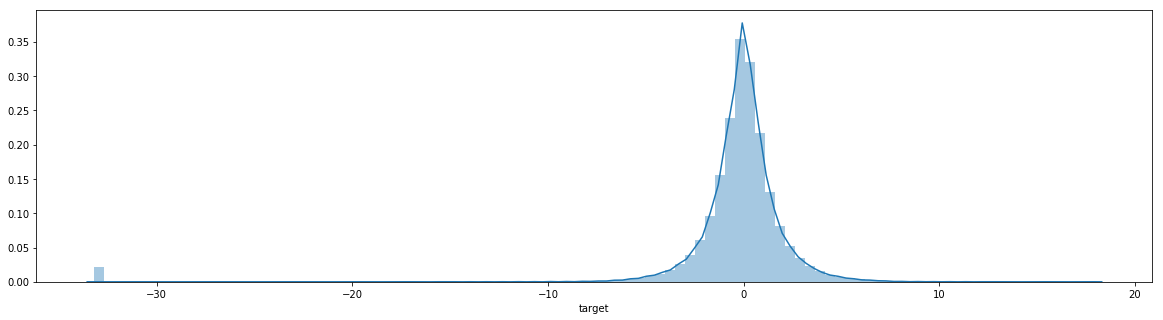

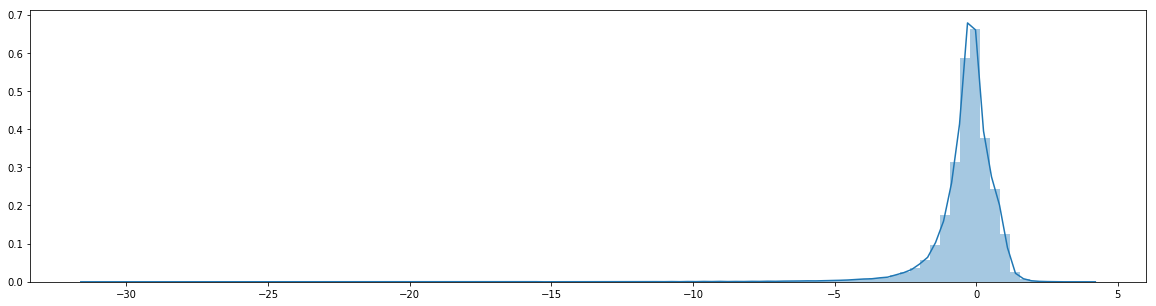

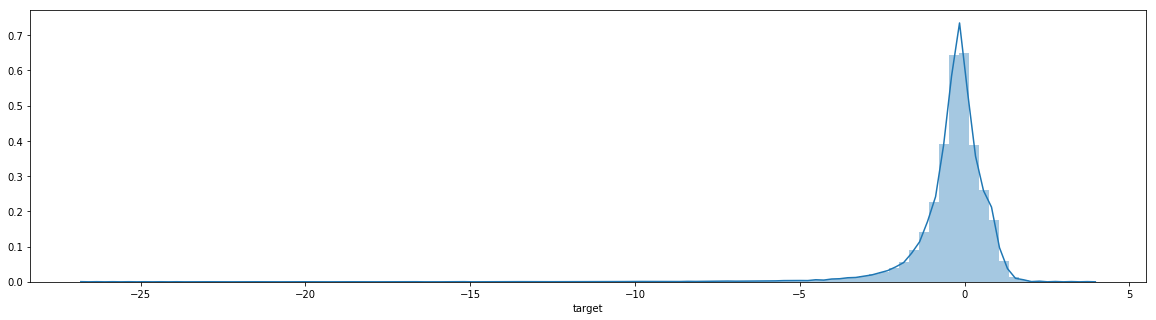

In [130]:
import seaborn as sns
plt.figure(figsize=(20, 5))
sns.distplot(df_train['target'],bins = 100)
plt.show()
plt.figure(figsize=(20, 5))
sns.distplot(train_pred,bins = 100)
plt.show()
plt.figure(figsize=(20, 5))
sns.distplot(single_pd['target'],bins = 100)
plt.show()

## Now, lets replace some nan values with 0


### Some card_id don't have purchases in historical transactions and some don't have in new transaction. When we call nunique function it gives nan values. Let's change them to 0, since it is more meaningful

In [131]:
# Setting nan values to zero since no purchases were made either in historical or new merchant transactions
df_train_new=df_train.copy()
df_test_new=df_test.copy()
for i in range(len(df_train_columns)):
    if 'merchant_id' in df_train_columns[i]:
        print(df_train_columns[i])
        df_train_new.loc[df_train[df_train_columns[i]].isnull(),df_train_columns[i]]=0
        df_test_new.loc[df_test[df_train_columns[i]].isnull(),df_train_columns[i]]=0

auth_hist_merchant_id_nunique
auth_hist_merchant_id_mean_mean
auth_hist_merchant_id_sum_sum
hist_merchant_id_nunique
hist_merchant_id_mean_mean
hist_merchant_id_sum_sum
new_hist_merchant_id_nunique
new_hist_merchant_id_mean_mean
new_hist_merchant_id_sum_sum


In [132]:
trn_data = lgb.Dataset(df_train_new[df_train_columns], label=df_train_new.target)#, categorical_feature=categorical_feats)
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68054 + 0.0289917
[400]	cv_agg's rmse: 3.66047 + 0.0282249
[600]	cv_agg's rmse: 3.65371 + 0.0275937
[800]	cv_agg's rmse: 3.6509 + 0.0275938
[1000]	cv_agg's rmse: 3.64947 + 0.0275353
[1200]	cv_agg's rmse: 3.64909 + 0.0271803
[1400]	cv_agg's rmse: 3.64885 + 0.0273266
[1600]	cv_agg's rmse: 3.64886 + 0.0270815
[1800]	cv_agg's rmse: 3.64904 + 0.0270222
[2000]	cv_agg's rmse: 3.64908 + 0.0266618
best cv score: 3.6486947841309614
best boost nums: 1484


with 'nthread'=48
[200]	cv_agg's rmse: 3.68076 + 0.0290093
[400]	cv_agg's rmse: 3.66073 + 0.0284285
[600]	cv_agg's rmse: 3.65306 + 0.0274417
[800]	cv_agg's rmse: 3.65015 + 0.0268612
[1000]	cv_agg's rmse: 3.64909 + 0.0269212
[1200]	cv_agg's rmse: 3.64854 + 0.0265023
[1400]	cv_agg's rmse: 3.64874 + 0.0260882
[1600]	cv_agg's rmse: 3.64889 + 0.025836
best cv score: 3.6485187362185263
best boost nums: 1195

In [133]:
clf = lgb.train(param, trn_data,len(lgb_cv["rmse-mean"]), valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.5728
[400]	training's rmse: 3.48505
[600]	training's rmse: 3.42803
[800]	training's rmse: 3.38432
[1000]	training's rmse: 3.34631
[1200]	training's rmse: 3.31305
[1400]	training's rmse: 3.28259


In [135]:
y_pred = clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('wang_newest_with_purchase_journeys_updated.csv', index=False)
#LB: 3.676

In [64]:
feature_importance_df=pd.DataFrame({'Feature':clf.feature_name(),'importance':clf.feature_importance()})
feature_importance_df.sort_values(by="importance",ascending=False,inplace=True)

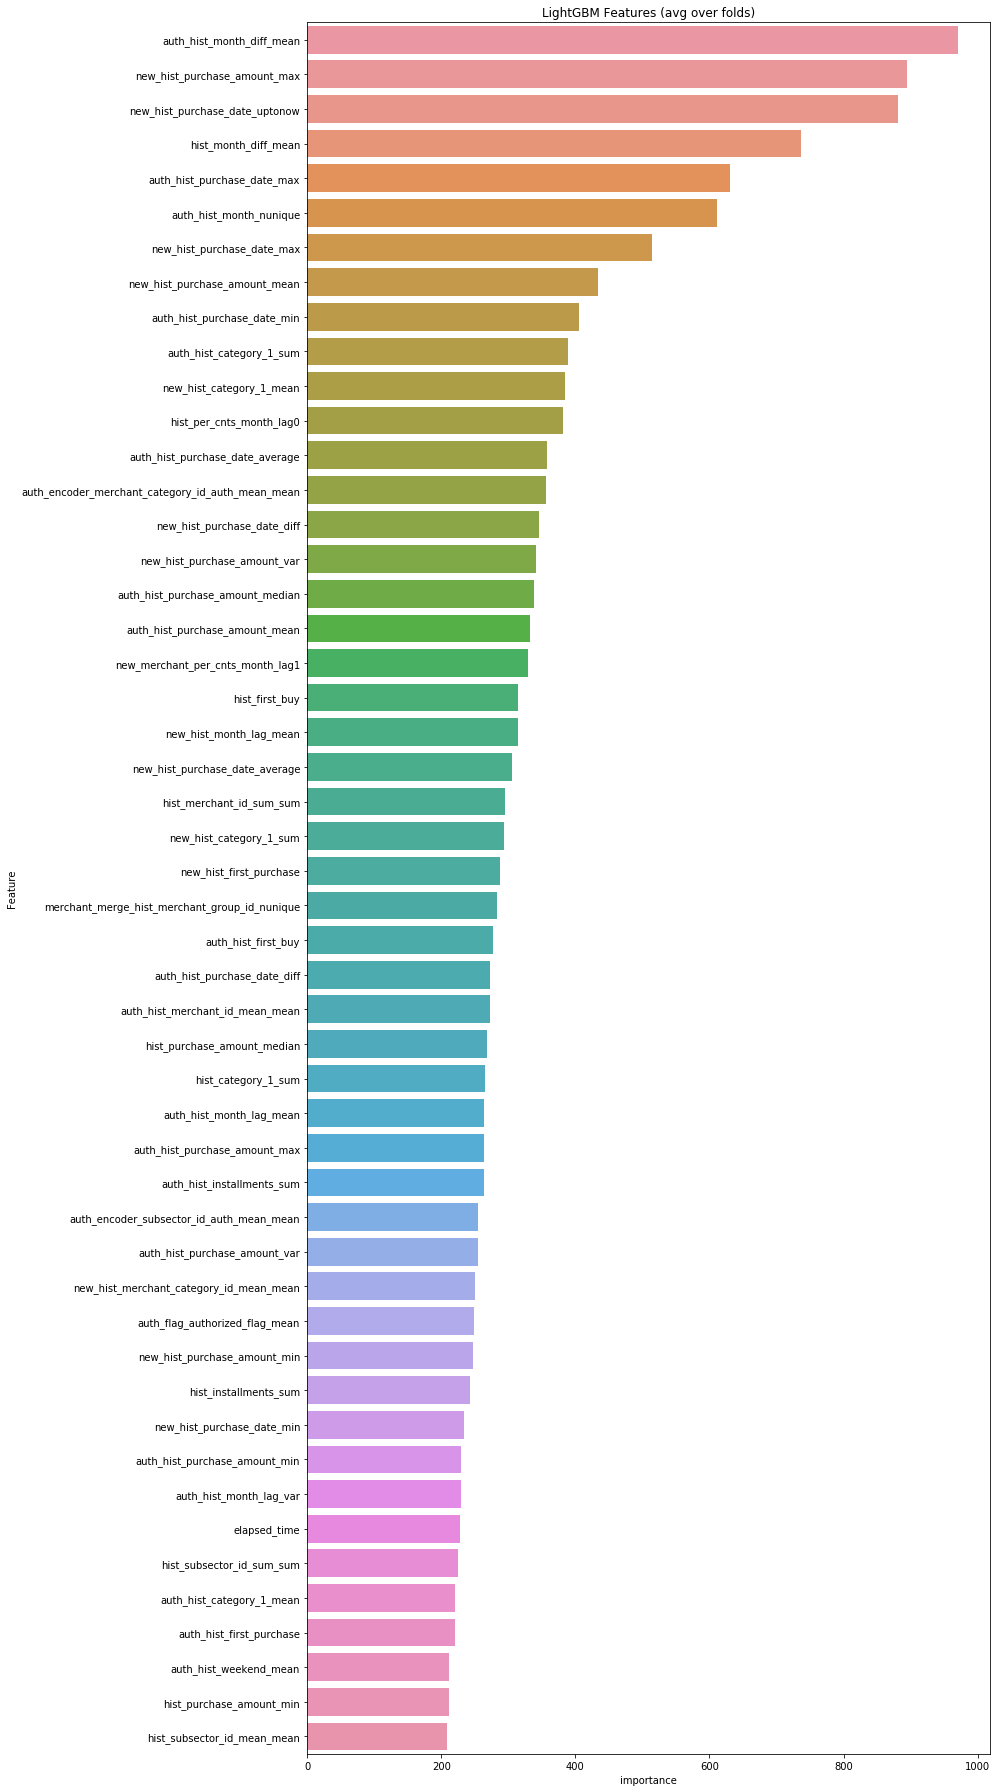

In [66]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=feature_importance_df[:50])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')

# Let's work with null values

In [99]:
list_null=df_train.isnull().any().index.tolist()

In [100]:
list_null_all=list_null.copy()

In [101]:
feature_importance_df[feature_importance_df.Feature.isin(list_null)][:30]
# Let's start will dealing with most important features
# simplest will be changing nan values of perchase amount to zero since purchase was not made at all

,Feature,importance
63,auth_hist_month_diff_mean,970
153,new_hist_purchase_amount_max,895
197,new_hist_purchase_date_uptonow,881
117,hist_month_diff_mean,736
56,auth_hist_purchase_date_max,630
34,auth_hist_month_nunique,611
164,new_hist_purchase_date_max,514
155,new_hist_purchase_amount_mean,433
57,auth_hist_purchase_date_min,405
67,auth_hist_category_1_sum,389


In [110]:
feature_importance_df.importance.sum()

35850

In [102]:
df_train2=df_train.copy()
df_test2=df_test.copy()

In [103]:
removed=[]
for item in list_null:
    if 'purchase_amount' in item:
#         df_train2.loc[df_train2[item].isnull(),item]=0
#         df_test2.loc[df_test2[item].isnull(),item]=0
        print(item)
#         removed.append(item)

auth_flag_purchase_amount_sum
auth_hist_purchase_amount_sum
auth_hist_purchase_amount_max
auth_hist_purchase_amount_min
auth_hist_purchase_amount_mean
auth_hist_purchase_amount_var
auth_hist_purchase_amount_median
hist_purchase_amount_sum
hist_purchase_amount_max
hist_purchase_amount_min
hist_purchase_amount_mean
hist_purchase_amount_var
hist_purchase_amount_median
new_hist_purchase_amount_sum
new_hist_purchase_amount_max
new_hist_purchase_amount_min
new_hist_purchase_amount_mean
new_hist_purchase_amount_var
new_hist_purchase_amount_median


### it will be more meaningful to change sum to zero. If we change rest of the values it might affect meaning. Since we might have 0 values for min,max,mean,var, and median for other cases. For ex, assume that max is 0 it doesn't mean that one never did purchases before.

In [108]:
removed=[]
for item in list_null:
    if 'purchase_amount' in item:
        if 'sum' in item:
            df_train2.loc[df_train2[item].isnull(),item]=0
            df_test2.loc[df_test2[item].isnull(),item]=0
            print(item)
            removed.append(item)
        #list_null.remove(item)

auth_flag_purchase_amount_sum
auth_hist_purchase_amount_sum
hist_purchase_amount_sum
new_hist_purchase_amount_sum


In [112]:
feature_importance_df[feature_importance_df.Feature.isin(removed)].importance.sum()/feature_importance_df.importance.sum()

0.017210599721059972

In [118]:
param['nthread']=6

In [119]:
trn_data = lgb.Dataset(df_train2[df_train_columns], label=df_train2.target)#, categorical_feature=categorical_feats)
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68084 + 0.0293701
[400]	cv_agg's rmse: 3.66053 + 0.0288477
[600]	cv_agg's rmse: 3.65334 + 0.0281447
[800]	cv_agg's rmse: 3.65021 + 0.0277402
[1000]	cv_agg's rmse: 3.6487 + 0.0272501
[1200]	cv_agg's rmse: 3.64846 + 0.0270452
[1400]	cv_agg's rmse: 3.64842 + 0.0269327
[1600]	cv_agg's rmse: 3.64847 + 0.0266739
[1800]	cv_agg's rmse: 3.64845 + 0.026459
best cv score: 3.6482914373173303
best boost nums: 1343


In [120]:
clf = lgb.train(param, trn_data,len(lgb_cv["rmse-mean"]), valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.57278
[400]	training's rmse: 3.4847
[600]	training's rmse: 3.42693
[800]	training's rmse: 3.38397
[1000]	training's rmse: 3.34668
[1200]	training's rmse: 3.3137


In [121]:
y_pred = clf.predict(df_test2[df_train_columns], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('wang_newest_with_purchase_journeys_updated2.csv', index=False)
#LB:3.679


In [143]:
import xgboost as xgb

In [147]:
trn_data = xgb.DMatrix(df_train[df_train_columns], label=df_train2.target)


In [166]:
xgb_params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'gamma': 0.1,
    'max_depth': 6,
    'eval_metric':'rmse',
    'lambda': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 6 
}

In [171]:
trn_data = xgb.DMatrix(df_train[df_train_columns], label=df_train.target)
xgb_cv=xgb.cv(xgb_params,trn_data,nfold=5)

TypeError: cv() got an unexpected keyword argument 'nfolds'

In [170]:
xgb_cv

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,3.908136,0.032525,3.901585,0.008636
1,3.870298,0.031084,3.856828,0.009342
2,3.838210,0.031223,3.818633,0.008305
3,3.811350,0.031407,3.785151,0.008450
4,3.788889,0.030902,3.757063,0.008893
5,3.770607,0.030851,3.731742,0.008846
6,3.755350,0.029834,3.710950,0.008911
7,3.742444,0.030590,3.691839,0.008407
8,3.731241,0.030876,3.675805,0.007259
9,3.722086,0.031283,3.660370,0.007239
